# *TP1 - DEEP LEARNING*

<table style="width:100%">
  <tr>
    <td style="text-align:left"><strong>Préparé par :</strong> EL Warraqi Imane</td>
    <td style="text-align:right"><strong>Encadré par :</strong> Pr. HAMZA EL KHALFI </td>
  </tr>
</table>

# Partie 2 : _Implémentation avec Pytorch_

### 2.2 Simplification du backward avec `torch.autograd`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt

**Chargement des données : CirclesData**



In [2]:
# charger les utilitaires de générations et visualisation des données
from utilitaires import *

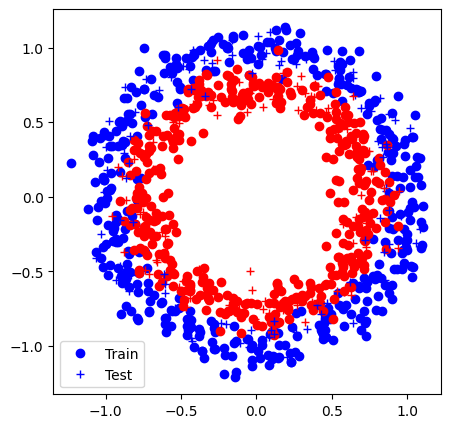

In [3]:
# charger / préparer / visualiser les données pour apprentissage
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
plot_data(data)

##### **Mise à jour de la fonction `init_params` :**

In [4]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: des nombres entiers
    out params: dictionnaire des paramètres
    """
    params = {}

    moyenne = 0
    ecart_type = 0.3
    
    #####################
    ## Votre code ici  ##
    #####################
    
    # remplir avec les paramètres Wh, Wy, bh, by
    params["Wh"] = torch.randn(nx, nh) * ecart_type + moyenne
    params["Wh"].requires_grad = True

    params["Wy"] = torch.randn(nh, ny) * ecart_type + moyenne
    params["Wy"].requires_grad = True

    params["bh"] = torch.zeros(1, nh, requires_grad=True)
    params["by"] = torch.zeros(1, ny, requires_grad=True)
    return params

Les deux fonctions `forward` et `loss_accuracy` sont inchangées par rapport à la partie précédente.

---

La fonction `backward` n'est plus utilisée grâce à l'autograd.

In [5]:
def forward(params, X):
    """
    - In    :
        params  : dictionnaire des paramètres
        X       : batch d'entrée (n_batch, nx)
    - Out   :
        yhat    : sortie du réseau Ŷ (prédiction)
        outputs : dictionnaire des étapes intermédiaires et la sortie Ŷ du réseau.
    """
    
    outputs = {}
    #####################
    ## Votre code ici  ##
    ##################### 
    # remplir avec les paramètres X, htilde, h, ytilde, yhat
    # Stocker l'entrée
    outputs["X"] = X

    # Couche cachée 
    htilde = torch.mm(X, params["Wh"]) + params["bh"]
    outputs["htilde"] = htilde

    # Activation tanh
    h = torch.tanh(htilde)
    outputs["h"] = h

    # Couche de sortie 
    ytilde = torch.mm(h, params["Wy"]) + params["by"]
    outputs["ytilde"] = ytilde

    # SoftMax pour obtenir la prédiction
    exp_scores = torch.exp(ytilde)
    yhat = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    outputs["yhat"] = yhat

    return outputs["yhat"], outputs


In [6]:
def loss_accuracy(Yhat, Y):
    """
    Calcul de la loss cross-entropy et de la précision
    - Yhat : sortie du réseau (nbatch, ny)
    - Y : vérité terrain (one-hot, nbatch, ny)
    
    Retourne :
    - loss : cross-entropy moyenne
    - acc : précision (taux de bonnes prédictions)
    """
    # Cross-entropy
    loss = -torch.sum(Y * torch.log(Yhat)) / Y.shape[0]

    # Précision
    _, pred_inds = torch.max(Yhat, dim=1)
    _, true_inds = torch.max(Y, dim=1)
    acc = torch.mean((pred_inds == true_inds).float())
    
    return loss, acc


##### **Mise à jour de la fonction `sgd` :**

In [7]:
def sgd(params, eta):
    """
    Mise à jour des paramètres par SGD
    - params : dictionnaire des poids et biais
    - grads : dictionnaire des gradients
    - eta : learning rate
    """
    #####################
    ## Votre code ici  ##
    #####################
    # mettre à jour les params
    #####################
    with torch.no_grad():  
        for key in params.keys():
            params[key] -= eta * params[key].grad   
            params[key].grad.zero_()

    return params

##### **Mise à jour de l'algorithme global :**

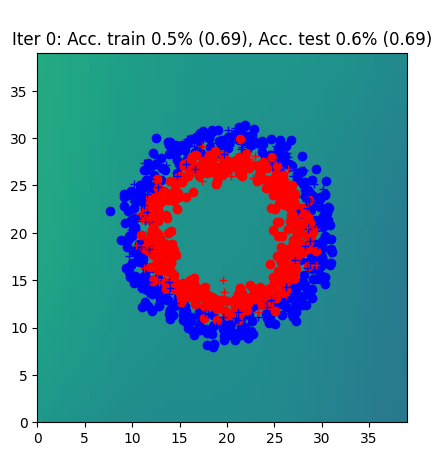

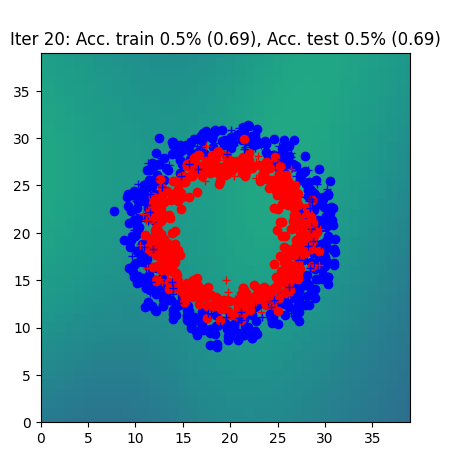

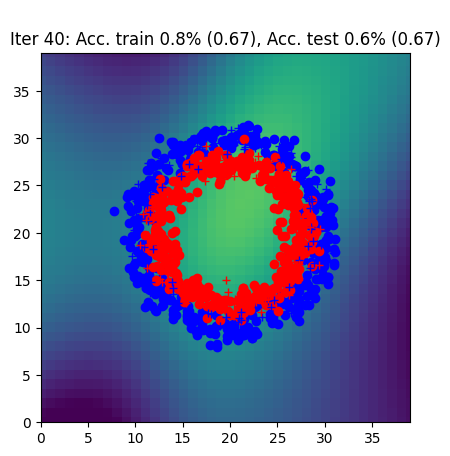

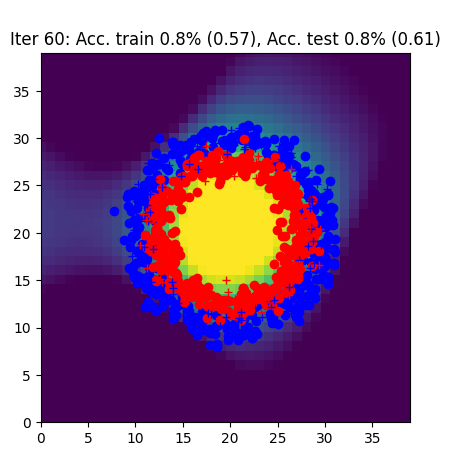

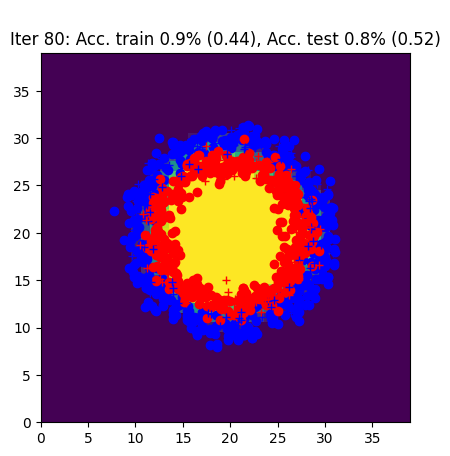

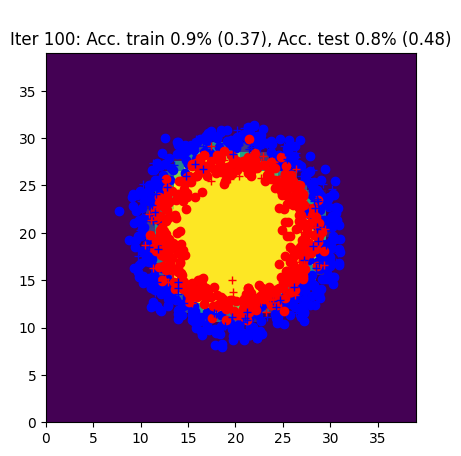

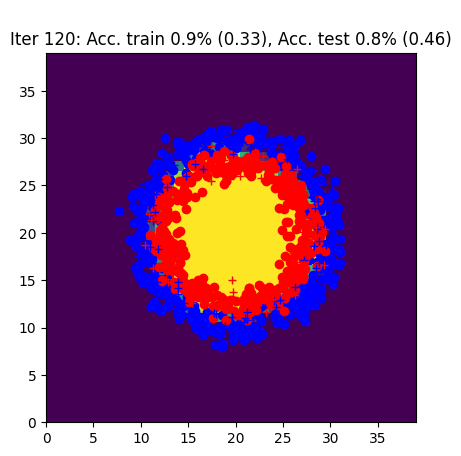

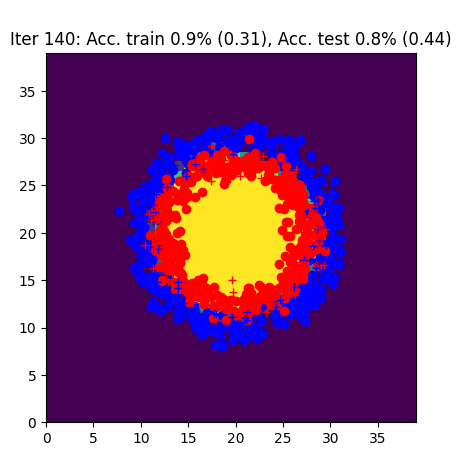

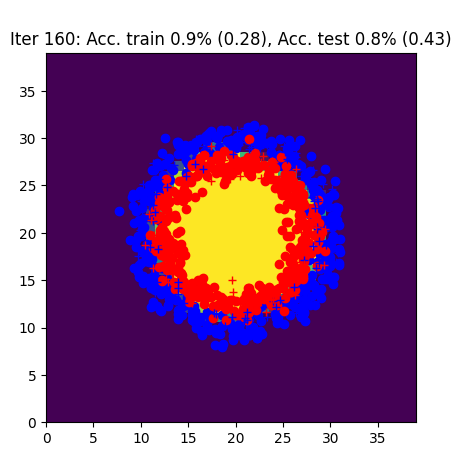

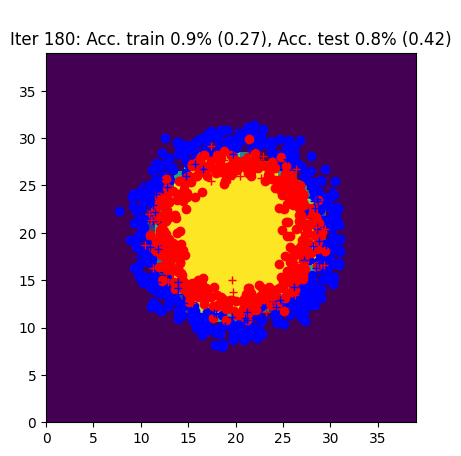

In [8]:
# Initialisation des paramètres
eta = 0.03
params = init_params(nx, nh, ny)

# Courbes (accuracy et loss)
curves = [[], [], [], [], [], []]

for iteration in range(200):

    # Mélange aléatoire des échantillons
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # Initialisation de la loss et accuracy par batch
    Loss = []
    Acc = []

    # Boucle sur les mini-batches
    for j in range(N // Nbatch):
        
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        #####################
        ## Étapes d'entraînement ##
        #####################
        # Forward pass
        Yhat, _ = forward(params, X)

        # Calcul de la perte et de l’accuracy
        loss, acc = loss_accuracy(Yhat, Y)
        Loss.append(loss.item() if torch.is_tensor(loss) else loss)
        Acc.append(acc)

        # Backward (calcul des gradients)
        loss.backward()

        # Mise à jour des poids
        params = sgd(params, eta)

    # Calcul de la moyenne par batch
    LBatch = np.mean(Loss)
    accBatch = np.mean(Acc)

    # Évaluation sur tout le dataset d'entraînement et test
    Yhat_train, _ = forward(params, data.Xtrain)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)

    Yhat_test, _ = forward(params, data.Xtest)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    
    # Affichage périodique
    if iteration % 20 == 0:
        title = f'\nIter {iteration}: Acc. train {acctrain:.1f}% ({Ltrain:.2f}), Acc. test {acctest:.1f}% ({Ltest:.2f})'
        Ygrid, _ = forward(params, data.Xgrid)
        plot_data_with_grid(data, Ygrid.detach().numpy(), title)

    # Sauvegarde des métriques
    curves[0].append(accBatch)
    curves[1].append(acctrain)
    curves[2].append(acctest)
    curves[3].append(LBatch)
    curves[4].append(Ltrain)
    curves[5].append(Ltest)
    


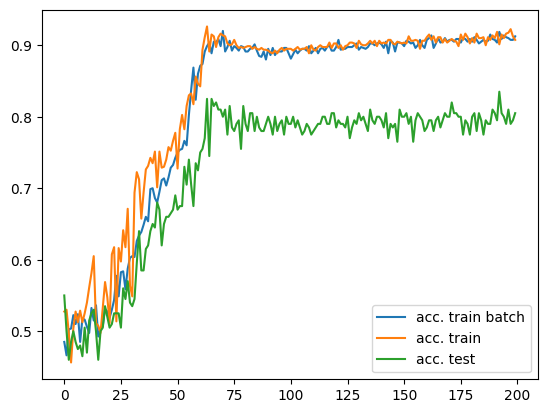

In [9]:
fig = plt.figure()
plt.plot(curves[0], label="acc. train batch")
plt.plot(curves[1], label="acc. train")
plt.plot(curves[2], label="acc. test")
plt.legend()
plt.show()

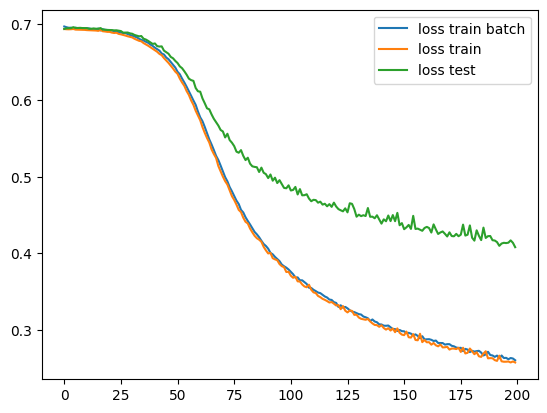

In [10]:
curves_np = [[x.detach().item() if torch.is_tensor(x) else x for x in c] for c in curves]

plt.plot(curves_np[3], label="loss train batch")
plt.plot(curves_np[4], label="loss train")
plt.plot(curves_np[5], label="loss test")
plt.legend()
plt.show()